In [1]:
## 20160521
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta  ## use this to increment targ by 1 year!!!!
import time
from time import gmtime, strftime

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
#import random

import sys
import os
os.chdir('C:/BankRisk')

In [2]:
rk = pd.read_csv("BkAvgAstPR_FailDate_BHC2_ult2015.csv", index_col=0)  # ultcert version
rk['xAsOf'] = pd.to_datetime(rk['xAsOf'])
rk['nAsOf'] = pd.to_datetime(rk['nAsOf'])
rk['FailDate'] = pd.to_datetime(rk['FailDate'])
rk.tail(3)

Rank   IDRSSD      xAsOf                                        xName  \
10759  10760  2809355 2002-09-30             FIRST TRUST COMPANY OF ONAGA, NA   
10760  10761  3037904 2002-06-30  MARQUETTE TRUST COMPANY OF SOUTH DAKOTA, NA   
10761  10762  3874891 2008-12-31          TEXAS FIRST BANK - RETAINED CHARTER   

      xState    xCert      nAsOf FailDate BkClass  Offices     ...      \
10759     KS  35589.0 2001-03-31      NaT     NaN      NaN     ...       
10760     SD  57326.0 2001-12-31      NaT     NaN      NaN     ...       
10761     TX  21960.0 2008-12-31      NaT      NM      1.0     ...       

      aeTotLn  aeDDep aeFDep  aeTotDep        pr_eTA    pr_eTAcs  pr_eTL  \
10759     0.0     0.0    0.0       0.0  4.736373e-06   99.999998     0.0   
10760     0.0     0.0    0.0       0.0  1.974775e-06  100.000000     0.0   
10761     0.0    66.0    0.0      66.0  4.458444e-07  100.000000     0.0   

       pr_eTLcs        pr_eDD    pr_eDDcs  
10759     100.0  0.000000e+00  105.924487  
10760     100.0  0.000000e+00  105.924487  
10761     100.0  7.834316e-07  105.924488  

[3 rows x 27 columns]

In [57]:
dfz = pd.read_csv("df3z_2015_allbanks.csv") # 20160521 update
dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
dfz = dfz[dfz['AsOf']<='2014-12-31']  # does not work if AsOf > 2014-12-31
dfcol = list(dfz.columns)
dfz.columns

Index(['Unnamed: 0', 'IDRSSD', 'AsOf', 'Name', 'State', 'Cert', 'eTotAst',
       'qNetInc', 'qNetII', 'qProv',
       ...
       'eTotrb', 'eALLL_Ln', 'mxCx', 'mxSfFst', 'mxCRE', 'mxCI', 'mxCard',
       'mxDDA', 'eRWA_TA', 'lnTotAst'],
      dtype='object', length=134)

In [58]:
len(dfz)

431445

In [59]:
rk[0:5]

Rank  IDRSSD      xAsOf                    xName xState    xCert  \
0     1  852218 2015-12-31  JPMORGAN CHASE BANK, NA     OH    628.0   
1     2  480228 2015-12-31      BANK OF AMERICA, NA     NC   3510.0   
2     3  476810 2015-12-31           CITIBANK, N.A.     SD   7213.0   
3     4  451965 2015-12-31     WELLS FARGO BANK, NA     SD   3511.0   
4     5  484422 2009-12-31        WACHOVIA BANK, NA     NC  33869.0   

       nAsOf   FailDate BkClass  Offices    ...           aeTotLn  \
0 2001-03-31        NaT       N   5547.0    ...      4.608670e+08   
1 2001-03-31 2009-01-16       N   4820.0    ...      6.161152e+08   
2 2001-03-31 2008-11-23       N    807.0    ...      4.859796e+08   
3 2001-03-31        NaT       N   6243.0    ...      4.586744e+08   
4 2001-03-31        NaT       N   3312.0    ...      2.546369e+08   

         aeDDep        aeFDep      aeTotDep    pr_eTA   pr_eTAcs    pr_eTL  \
0  5.710782e+08  2.527046e+08  8.237827e+08  9.127740   9.127740  5.470572   
1  7.159990e+08  1.100090e+08  8.260080e+08  7.970853  17.098593  7.313395   
2  2.470630e+08  4.301490e+08  6.772120e+08  6.749630  23.848224  5.768663   
3  4.985467e+08  5.936475e+07  5.579114e+08  4.922934  28.771157  5.444545   
4  2.704156e+08  2.469325e+07  2.951088e+08  2.983418  31.754575  3.022585   

    pr_eTLcs    pr_eDD   pr_eDDcs  
0   5.470572  6.778798   6.778798  
1  12.783967  8.499033  15.277831  
2  18.552629  2.932681  18.210512  
3  23.997174  5.917837  24.128348  
4  27.019759  3.209880  27.338229  

[5 rows x 27 columns]

In [60]:
dfcol[-56:][0:5]  ## want to start with rcTotLn as first of all ratios

['rcTotLn', 'rcCx', 'rcSfRev', 'rcSfTD', 'rcMult']

In [61]:
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
#xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
xcol

['rcTotLn',
 'qnTotLn',
 'rNIM',
 'rPPNR',
 'rROA',
 'rROE',
 'rEff',
 'eLn_Dep',
 'aFF_TA',
 'eBrok_Dep',
 'eT1rb',
 'eTotrb',
 'eALLL_Ln',
 'lnTotAst']

In [62]:
#dfz['AsOf'] = pd.to_datetime(dfz['AsOf'])
dfr = dfz[dfz['AsOf']>='2001-12-31'][['IDRSSD','AsOf','Name','State','eTotAst']+xcol]

In [63]:
dfr.tail(2)

IDRSSD       AsOf                            Name State  eTotAst  \
456895  4589857 2014-06-30  INVESCO NATIONAL TRUST COMPANY    GA  40112.0   
456896  4589857 2014-09-30  INVESCO NATIONAL TRUST COMPANY    GA  39151.0   

        rcTotLn  qnTotLn        rNIM     rPPNR       rROA       rROE  \
456895      NaN      0.0         NaN       NaN        NaN        NaN   
456896      0.0      0.0  188.235294  3.837989  18.953723  17.982972   

             rEff  eLn_Dep    aFF_TA  eBrok_Dep       eT1rb      eTotrb  \
456895        NaN      0.0  0.638234        0.0  213.794236  213.794236   
456896  94.549092      0.0  0.000000        0.0  183.073635  183.073635   

        eALLL_Ln   lnTotAst  
456895       0.0  10.599431  
456896       0.0  10.575181

In [64]:
len(dfr)

405040

In [65]:
## add faildate (if it hasn't already been added):
if 'FailDate' not in list(dfr.columns): dfr = dfr.merge(rk[['IDRSSD','FailDate']],how='left',on='IDRSSD')

In [66]:
## calculate months-to-fail (mtf) and fail flags (f6 and f12):
dfr['mtf'] = ((dfr['FailDate'] - dfr['AsOf'])/np.timedelta64(1,'M')) 
dfr['mtf2'] = dfr.apply(lambda x: round(x['mtf'],0),axis=1)
dfr['f2'] = ((dfr['mtf'] <= 6.0) & (dfr['mtf'] >= 0.0))*1
dfr['f4'] = ((dfr['mtf'] <= 12.0) & (dfr['mtf'] >= 0.0))*1
dfr['f6'] = ((dfr['mtf'] <= 18.0) & (dfr['mtf'] >= 0.0))*1
dfr['f8'] = ((dfr['mtf'] <= 24.0) & (dfr['mtf'] >= 0.0))*1
dfr[dfr['FailDate']>'1990'].tail(10)

IDRSSD       AsOf                   Name State  eTotAst    rcTotLn  \
401950  3640854 2010-12-31  PISGAH COMMUNITY BANK    NC  42376.0  28.150487   
401951  3640854 2011-03-31  PISGAH COMMUNITY BANK    NC  37254.0   8.929288   
401952  3640854 2011-06-30  PISGAH COMMUNITY BANK    NC  30273.0   8.503535   
401953  3640854 2011-09-30  PISGAH COMMUNITY BANK    NC  30326.0   6.575220   
401954  3640854 2011-12-31  PISGAH COMMUNITY BANK    NC  28120.0   1.430248   
401955  3640854 2012-03-31  PISGAH COMMUNITY BANK    NC  27152.0   2.384150   
401956  3640854 2012-06-30  PISGAH COMMUNITY BANK    NC  27272.0   3.607183   
401957  3640854 2012-09-30  PISGAH COMMUNITY BANK    NC  27126.0   2.767538   
401958  3640854 2012-12-31  PISGAH COMMUNITY BANK    NC  24844.0   3.571429   
401959  3640854 2013-03-31  PISGAH COMMUNITY BANK    NC  21880.0   4.476975   

          qnTotLn      rNIM     rPPNR       rROA ...    eTotrb   eALLL_Ln  \
401950  23.925972  1.477079 -1.921769 -18.226779 ...  1.820415   4.658121   
401951  17.008591  1.501112 -3.117728 -10.539127 ...  4.962240   9.265289   
401952  21.446963  1.627686 -4.269489 -10.664828 ...  4.205588   9.130049   
401953  22.193740  1.812781 -5.113951 -11.027282 ...  3.881005   8.688613   
401954  18.812332  2.028930 -6.126587  -9.089617 ...  4.278839   9.745355   
401955  25.039539  2.097654 -6.350320  -6.577475 ...  4.561760  10.918437   
401956  24.826110  2.210453 -7.173657  -7.180697 ...  4.254765   8.768801   
401957  30.337148  2.105704 -7.160776  -7.164372 ...  4.221197   8.890119   
401958  20.492884  1.927205 -7.261747  -7.265452 ...  4.766264   9.330094   
401959  19.035231  1.919126 -6.838070  -5.395423 ...  5.006596   6.525940   

         lnTotAst   FailDate        mtf  mtf2  f2  f4  f6 f8  
401950  10.654337 2013-05-10  28.288055  28.0   0   0   0  0  
401951  10.525515 2013-05-10  25.331116  25.0   0   0   0  0  
401952  10.318012 2013-05-10  22.341321  22.0   0   0   0  1  
401953  10.319761 2013-05-10  19.318672  19.0   0   0   0  1  
401954  10.244236 2013-05-10  16.296023  16.0   0   0   1  1  
401955  10.209206 2013-05-10  13.306228  13.0   0   0   1  1  
401956  10.213616 2013-05-10  10.316434  10.0   0   1   1  1  
401957  10.208248 2013-05-10   7.293784   7.0   0   1   1  1  
401958  10.120372 2013-05-10   4.271135   4.0   1   1   1  1  
401959   9.993328 2013-05-10   1.314195   1.0   1   1   1  1  

[10 rows x 26 columns]

In [67]:
dfr[dfr['FailDate']>'1990'][['AsOf','IDRSSD','FailDate','mtf','mtf2']].tail(10)

AsOf   IDRSSD   FailDate        mtf  mtf2
401950 2010-12-31  3640854 2013-05-10  28.288055  28.0
401951 2011-03-31  3640854 2013-05-10  25.331116  25.0
401952 2011-06-30  3640854 2013-05-10  22.341321  22.0
401953 2011-09-30  3640854 2013-05-10  19.318672  19.0
401954 2011-12-31  3640854 2013-05-10  16.296023  16.0
401955 2012-03-31  3640854 2013-05-10  13.306228  13.0
401956 2012-06-30  3640854 2013-05-10  10.316434  10.0
401957 2012-09-30  3640854 2013-05-10   7.293784   7.0
401958 2012-12-31  3640854 2013-05-10   4.271135   4.0
401959 2013-03-31  3640854 2013-05-10   1.314195   1.0

In [68]:
## issues:  Ln_Dep, Brok_Dep ratios:
dfr[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [69]:
dfr.ix[dfr['eLn_Dep'].idxmax()]

IDRSSD                               3376461
AsOf                     2005-09-30 00:00:00
Name         LEHMAN BROTHERS COMMERCIAL BANK
State                                     UT
eTotAst                          1.32523e+06
rcTotLn                                  NaN
qnTotLn                                    0
rNIM                                     NaN
rPPNR                                    NaN
rROA                                     NaN
rROE                                     NaN
rEff                                     NaN
eLn_Dep                          1.18828e+08
aFF_TA                               3.85946
eBrok_Dep                                  0
eT1rb                                15.0255
eTotrb                               15.0255
eALLL_Ln                                   0
lnTotAst                             14.0971
FailDate                                 NaT
mtf                                      NaN
mtf2                                     NaN
f2        

In [70]:
## Don't run this unless something has changed!!!!!!!!!
dfr.to_csv("logistic_rawdata.csv")

In [71]:
len(dfr)

405040

In [72]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [73]:
## curr date is 2010-12-31, but cut off dataset at 2009-12-31, then adjust for any fail flags later than 2010-12-31:
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test
dfh = dfr[(dfr['AsOf']<=targ)][['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']+xcol]
#dfr09 = sm.add_constant(dfr09)
len(dfh)

265388

In [74]:
dfh.columns[8:]

Index(['rcTotLn', 'qnTotLn', 'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff',
       'eLn_Dep', 'aFF_TA', 'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln',
       'lnTotAst'],
      dtype='object')

In [75]:
dfh[['eLn_Dep','aFF_TA','eBrok_Dep','eALLL_Ln']].max()

eLn_Dep      1.188277e+08
aFF_TA       1.242405e+03
eBrok_Dep    7.002056e+03
eALLL_Ln     1.500000e+04
dtype: float64

In [76]:
## screening criteria, remove outliers: (10/29/15 add eT1rb and lnTotAst screens)
dfh.dropna(how='any',inplace=True,subset=dfh.columns[8:])  # delete any ratio columns with NaN values (note columns[8:])
dfh= dfh[dfh['eLn_Dep']<=1000]
dfh= dfh[dfh['eBrok_Dep']<=100]
dfh= dfh[dfh['eALLL_Ln']<=100]
dfh= dfh[dfh['rROE']>=-200]
dfh= dfh[dfh['eT1rb']<=200]   # added 10/29/15
dfh= dfh[dfh['lnTotAst']>=2]  # added 10/29/15
len(dfh)

259210

In [77]:
# 20160428 handles leap years now.
targ2 = pd.to_datetime(targ.day + targ.month*100 + (targ.year + 1)*10000,format='%Y%m%d')
targ2

Timestamp('2010-12-31 00:00:00')

In [78]:
## set fflags to zero if FailDate after target date (12/31/2009); that is, for f4
dfh.ix[dfh.FailDate>targ2,['f2','f4','f6','f8']] = [0,0,0,0]

In [79]:
dfh.ix[(dfh.FailDate>'2010-09-01')&(dfh.FailDate<'2012-01-01')&(dfh.AsOf>'2009-09-01'),\
       ['IDRSSD','AsOf','Name','FailDate','f2','f4','f6','f8']].head()

IDRSSD       AsOf                 Name   FailDate  f2  f4  f6  f8
4658   16337 2009-09-30         WAKULLA BANK 2010-10-01   0   0   1   1
4659   16337 2009-12-31         WAKULLA BANK 2010-10-01   0   1   1   1
6017   20370 2009-09-30  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
6018   20370 2009-12-31  FIRST HERITAGE BANK 2011-05-27   0   0   0   0
7011   23241 2009-09-30      INTEGRA BANK NA 2011-07-29   0   0   0   0

In [80]:
## regressions:
fml = 'f4 ~ ' + ' + '.join(xcol)
fml

'f4 ~ rcTotLn + qnTotLn + rNIM + rPPNR + rROA + rROE + rEff + eLn_Dep + aFF_TA + eBrok_Dep + eT1rb + eTotrb + eALLL_Ln + lnTotAst'

In [81]:
try:
  md = smf.logit(formula=fml, data=dfh).fit()
  print(md.summary())
except:
  print("Full model didn't work")

         Current function value: inf
         Iterations: 35
Full model didn't work


In [82]:
## stepwise regressions:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

## create 2-var models:
topx = 2
def dv1_topx(group):
  return group.sort_index(by='r1', ascending=False)[:topx]

dv1 = pd.DataFrame(columns=['fx','v1', 'r1']) # c1: category1, v1: variable1, r1: rsquared1
for fx in ['f2','f4','f6']:
  for v in xcol:
    y, X = dmatrices( fx + ' ~ ' + v , data=dfh, return_type='dataframe')
    try:
      res = sm.Logit(y, X).fit()
      dv1 = dv1.append({'fx': fx,'v1': v, 'r1': res.prsquared}, ignore_index=True)
    except:
      pass

dv1g = dv1.groupby(['fx'])
dv1t = dv1g.apply(dv1_topx)
dv1t.index = np.arange(len(dv1t))

# stores r-sq values for all 2-var combos:
dv2 = pd.DataFrame(columns=['fx','v1', 'r1', 'v2', 'r2'])
st2 = set(frozenset({'fx','x', 'y'}))  # to retain processed var-pairs

for idx, row in dv1t.iterrows():
  for v in xcol:
    if (row['v1'] == v) | ({row['fx'], v , row['v1']} in st2):
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        res = sm.Logit(y, X).fit()
        dv2 = dv2.append({'fx':row['fx'], 'v1':row['v1'], 'r1':row['r1'], 'v2':v, 'r2': res.prsquared}, ignore_index=True)
      except:
        pass
      st2.add(frozenset({row['fx'], v, row['v1']}))

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


2016-05-21 13:20:51
Optimization terminated successfully.
         Current function value: 0.010368
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.009019
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010373
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010116
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.008902
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.005301
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010372
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010353
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.010345
         Iterations 11
Optimization terminated successfully.
         Curren

In [83]:
dv1t

fx      v1        r1
0  f2   eT1rb  0.522181
1  f2  eTotrb  0.498840
2  f4   eT1rb  0.399541
3  f4    rROE  0.397054
4  f6    rROE  0.300326
5  f6   eT1rb  0.292186

In [84]:
# function to select topx for each lead variable:
def get_topx_2var(group):
  return group.sort_index(by=['r2','r1'], ascending=False)[:topx]

grouped = dv2.groupby(['fx'])
dv2a = grouped.apply(get_topx_2var)
dv2a = dv2a.sort_index(by=['fx','r2','r1'], ascending=[True,False,False])
dv2a.index = np.arange(len(dv2a))
dv2a

fx     v1        r1       v2        r2
0  f2  eT1rb  0.522181     rROE  0.572503
1  f2  eT1rb  0.522181  qnTotLn  0.564419
2  f4  eT1rb  0.399541  qnTotLn  0.485642
3  f4  eT1rb  0.399541     rROE  0.477492
4  f6  eT1rb  0.292186  qnTotLn  0.398684
5  f6  eT1rb  0.292186     rROA  0.378671

In [85]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 3-var combos:
# stores r-sq values for all 3-var combos:
dv3 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2', 'v3', 'r3'])
cv3 = pd.DataFrame(columns=['idx','v3','Int','c1','c2','c3'])
st3 = set(frozenset({'fx','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv2a.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) :
      pass
    elif {row['fx'], v , row['v1'], row['v2']} in st3:
      pass
    else:
      y, X = dmatrices( row['fx'] + ' ~ ' + row['v1'] + ' + ' + row['v2'] + ' + ' + v , data = dfh, return_type='dataframe')
      try:
        st3.add(frozenset({row['fx'],v, row['v1'], row['v2']}))
        res = sm.Logit(y, X).fit()
        dv3 = dv3.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],\
                          'r2':row['r2'],'v3':v,'r3': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3']
        cm['idx'] = idx
        cm['v3'] = v
        cv3 = cv3.append(cm.ix[0])
      except:
        pass

cv3arch = cv3.copy()
dv3arch = dv3.copy()
#cv3.reset_index(drop=True,inplace=True)
dv3.reset_index(drop=True,inplace=True)
dv3 = dv3.merge(cv3, how='inner', on=['idx','v3'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2016-05-21 13:22:53
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004419
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004434
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004423
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004411
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004216
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004406
         Iterat

In [86]:
topn = 2
# function to select top 3 for each lead variable:
def get_topx_3var(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topx]

def get_topn_rc(group):
  return group.sort_index(by=['r3','r2','r1'], ascending=False)[:topn]

dv3g = dv3.groupby(['fx','v1','v2'])  #  allows topx for each primary 2-var pair
dv3a = dv3g.apply(get_topx_3var)  ## finds best topx models from each 3-var combo
dv3ag = dv3a.groupby(['fx'])  # prep to find topn best models for each product category
dv3b = dv3ag.apply(get_topn_rc)  # find topn models among all 3-var models
dv3b.index = np.arange(len(dv3b))
dv3b

idx  fx     v1        r1       v2        r2         v3        r3       Int  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651 -2.376700   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503  eBrok_Dep  0.593579 -2.262260   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306 -0.551524   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804 -1.591131   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376 -0.262304   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684       rROA  0.427395 -0.786348   

         c1        c2        c3  
0 -0.477164 -0.025604  0.087899  
1 -0.501399 -0.029879  0.038361  
2 -0.525912  0.125261 -0.325274  
3 -0.423253  0.123065 -0.028369  
4 -0.534329  0.213801  0.041452  
5 -0.429293  0.156714 -0.303840

In [87]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# prep for 4-var combos:
# stores r-sq values for all 3-var combos:
dv4 = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4 = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])
st4 = set(frozenset({'fx','w','x', 'y', 'z'}))  # to retain processed var-triples

for idx, row in dv3b.iterrows():
  for v in xcol:
    if (row['v1'] == v) | (row['v2'] == v) | (row['v3'] == v):
      pass
    elif {row['fx'], v , row['v1'], row['v2'], row['v3']} in st4:
      pass
    else:
      y, X = dmatrices( row['fx']+' ~ '+ row['v1'] +' + '+ row['v2'] +' + '+ row['v3'] +' + '+ v , data = dfh, return_type='dataframe')
      st4.add(frozenset({row['fx'],v, row['v1'], row['v2'], row['v3']}))
      try:
        res = sm.Logit(y, X).fit()
        dv4 = dv4.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                          'v3':row['v3'],'r3': row['r3'], 'v4':v,'r4': res.prsquared},ignore_index=True)
        cm = pd.DataFrame(res.params).T
        cm.columns = ['Int','c1','c2','c3','c4']
        cm['idx'] = idx
        cm['v4'] = v
        cv4 = cv4.append(cm.ix[0])
      except:
        pass

cv4 = cv4.reset_index(drop=True)
dv4 = dv4.reset_index(drop=True)
dv4 = dv4.merge(cv4, how='inner', on=['idx','v4'])

print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2016-05-21 13:24:30
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.004189
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.004194
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004176
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004182
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004165
         Iterations 15
Optimization terminated successfully.
         Curren

In [88]:
# function to select top 2 for each lead variable set:
def get_topx_4var(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:3]

def get_topn_4fx(group):
  return group.sort_index(by=['r4','r3','r2','r1'], ascending=False)[:2]

dv4g = dv4.groupby(['fx','v1','v2','v3'])  #  allows topx for each primary 2-var pair
dv4a = dv4g.apply(get_topx_4var)  ## finds best topx models from each 3-var combo
dv4ag = dv4a.groupby(['fx'])  # prep to find topn best models for each product category
dv4b = dv4ag.apply(get_topn_4fx)  # find topn models among all 3-var models
dv4b.index = np.arange(len(dv4b))
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [89]:
dv4b.to_csv("f246_params_"+alt+str(thresh)+"mm2_2009.csv")

In [90]:
dnbr=dfr[['AsOf','f2','f4','f6','f8']].groupby('AsOf').sum()
dnbr['2009':'2011']

f2   f4   f6   f8
AsOf                         
2009-03-31  63  135  205  256
2009-06-30  79  153  211  254
2009-09-30  72  142  193  236
2009-12-31  74  132  175  216
2010-03-31  70  121  163  194
2010-06-30  58  101  142  166
2010-09-30  51   94  124  145
2010-12-31  43   84  108  124
2011-03-31  42   73   94  104
2011-06-30  41   65   81   96
2011-09-30  30   51   61   78
2011-12-31  24   40   55   63

In [91]:
### run forecasts in dff:

In [92]:
dff = dfr.copy()
len(dff)

405040

In [93]:
dff = dff[dff['eLn_Dep']<=1000]
dff = dff[dff['eBrok_Dep']<=100]
dff = dff[dff['eALLL_Ln']<=100]
dff = dff[dff['rROE']>=-200]
dff= dff[dff['eT1rb']<=200]   # added 10/29/15
dff= dff[dff['lnTotAst']>=2]  # added 10/29/15
len(dff)

395257

In [94]:
# Add intercept:
dff['Intercept'] = 1.
dff.tail(2)

IDRSSD       AsOf                            Name State   eTotAst  \
405035  4569167 2014-12-31             NEW TRADITIONS BANK    FL  505699.0   
405039  4589857 2014-09-30  INVESCO NATIONAL TRUST COMPANY    GA   39151.0   

         rcTotLn  qnTotLn        rNIM     rPPNR       rROA    ...     \
405035  0.048897      0.0    3.429863  1.871445   0.938726    ...      
405039  0.000000      0.0  188.235294  3.837989  18.953723    ...      

        eALLL_Ln   lnTotAst  FailDate  mtf  mtf2  f2  f4  f6  f8 Intercept  
405035  0.321902  13.133697       NaT  NaN   NaN   0   0   0   0       1.0  
405039  0.000000  10.575181       NaT  NaN   NaN   0   0   0   0       1.0  

[2 rows x 27 columns]

In [95]:
## rerun models for dfh and dff tables:
dv4r = pd.DataFrame(columns=['idx','fx','v1', 'r1', 'v2', 'r2','v3', 'r3','v4','r4'])
cv4r = pd.DataFrame(columns=['idx','v4','Int','c1','c2','c3','c4'])

for idx, row in dv4b.iterrows():
  fv = row['fx']
  x = idx
  eqnc = fv + " ~ " + " + ".join(row[['v1', 'v2', 'v3','v4']])  # regression eqn
  pvar = ["Intercept", row['v1'], row['v2'], row['v3'], row['v4']]  # vars for predictions
  yc, Xc = dmatrices(eqnc , data=dfh, return_type='dataframe')
  res = sm.Logit(yc, Xc).fit()
  dv4r = dv4r.append({'idx':idx,'fx':row['fx'],'v1':row['v1'],'r1':row['r1'],'v2':row['v2'],'r2':row['r2'],\
                    'v3':row['v3'],'r3': row['r3'], 'v4':row['v4'],'r4': res.prsquared},ignore_index=True)
  cmr = pd.DataFrame(res.params).T
  cmr.columns = ['Int','c1','c2','c3','c4']
  cmr['idx'] = idx
  cmr['v4'] = row['v4']
  cv4r = cv4r.append(cmr.ix[0])
  pred_tot = res.predict(Xc)
  dfh[fv+'_'+str(x)] = pred_tot
  p_tot = res.predict(dff[pvar])  # forecasts  dff: future vars
  dff[fv+'_'+str(x)] = p_tot

cv4r = cv4r.reset_index(drop=True)
dv4r = dv4r.reset_index(drop=True)
dv4r = dv4r.merge(cv4r, how='inner', on=['idx','v4'])


Optimization terminated successfully.
         Current function value: 0.004026
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.004090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.010472
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.010502
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.018770
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.018829
         Iterations 12


In [96]:
dv4r

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  1.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  5.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [97]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [98]:
## annotations for graphs: vars & r-sq:
df4lst1 = []
df4lst2 = []
for i in np.arange(len(dv4r)):
  ds1 = dv4r.ix[i]['v1'] + ', ' + dv4r.ix[i]['v2'] + ', ' 
  ds2 = dv4r.ix[i]['v3'] + ',' + dv4r.ix[i]['v4'] +': '+ str(round(dv4r.ix[i]['r4']*100,1))
  df4lst1 = df4lst1 + [ds1]
  df4lst2 = df4lst2 + [ds2]

dv4r['Annot1'] = df4lst1
dv4r['Annot2'] = df4lst2
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0  0.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651  eBrok_Dep   
1  1.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  eT1rb, rROE,    
1  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.2  
1   qnTotLn,lnTotAst: 60.6

In [99]:
dff.head()

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   
2      37 2002-06-30  BANK OF HANCOCK COUNTY    GA  69304.0  0.364757   
3      37 2002-09-30  BANK OF HANCOCK COUNTY    GA  71970.0  0.495989   
4      37 2002-12-31  BANK OF HANCOCK COUNTY    GA  74327.0  0.610962   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   
2  0.206747  4.599485  1.927457  1.294383    ...      0   0   0        1.0   
3  0.325492  4.492631  1.833764  1.235163    ...      0   0   0        1.0   
4  0.268236  4.436347  1.816232  1.214158    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   
2  2.624992e-08  3.539017e-08  3.656513e-07  2.750531e-08  5.105488e-07   
3  4.456546e-08  5.939042e-08  5.798267e-07  5.008500e-08  8.313529e-07   
4  1.606111e-08  2.269976e-08  2.410813e-07  1.621047e-08  3.368549e-07   

       f6_5  
0  0.000002  
1  0.000002  
2  0.000003  
3  0.000004  
4  0.000002  

[5 rows x 33 columns]

In [100]:
fcol = [x for x in list(dff.columns) if x[0:1]=='f']
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [101]:
fnbr = dff[['AsOf']+fcol].groupby('AsOf').sum()
fnbr.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
fnbr[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = fnbr[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
fnbr.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
fnbr.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
fnbr.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
fnbr.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

favg = dff[['AsOf']+fcol].groupby('AsOf').mean()
favg.rename(columns={'f2_0':'f2_0f','f2_1':'f2_1f','f4_2':'f4_2f','f4_3':'f4_3f','f6_4':'f6_4f','f6_5':'f6_5f'},inplace=True)
favg[['f2_0p','f2_1p','f4_2p','f4_3p','f6_4p','f6_5p']] = favg[['f2_0f','f2_1f','f4_2f','f4_3f','f6_4f','f6_5f']]
favg.ix[:'2009-12-31',['f2_0p','f2_1p','f4_2p','f4_3p']] = np.nan
favg.ix[:'2009-06-30',['f6_4p','f6_5p']] = np.nan
favg.loc['2010-03-31':,['f2_0f','f2_1f','f4_2f','f4_3f']] = np.nan
favg.loc['2009-09-30':,['f6_4f','f6_5f']] = np.nan

fnbr['2009':'2010']

f2   f4   f6   f8      f2_0f      f2_1f       f4_2f       f4_3f  \
AsOf                                                                          
2009-03-31  55  127  197  248  39.917977  38.468347   91.283776   92.637105   
2009-06-30  59  131  189  232  49.093167  50.077017  109.054071  107.127208   
2009-09-30  52  119  170  213  48.977391  50.292186  113.122369  109.162461   
2009-12-31  62  120  163  204  73.303020  74.859571  150.570430  146.923207   
2010-03-31  53  104  146  177        NaN        NaN         NaN         NaN   
2010-06-30  43   86  127  151        NaN        NaN         NaN         NaN   
2010-09-30  36   78  108  127        NaN        NaN         NaN         NaN   
2010-12-31  34   75   99  115        NaN        NaN         NaN         NaN   

                 f6_4f       f6_5f      f2_0p      f2_1p       f4_2p  \
AsOf                                                                   
2009-03-31  136.599773  133.968930        NaN        NaN         NaN   
2009-06-30  154.836742  155.632097        NaN        NaN         NaN   
2009-09-30         NaN         NaN        NaN        NaN         NaN   
2009-12-31         NaN         NaN        NaN        NaN         NaN   
2010-03-31         NaN         NaN  70.684623  74.628322  140.236146   
2010-06-30         NaN         NaN  58.258775  63.955999  117.360695   
2010-09-30         NaN         NaN  52.636542  58.346461  105.980154   
2010-12-31         NaN         NaN  52.011692  56.621807  105.626960   

                 f4_3p       f6_4p       f6_5p  
AsOf                                            
2009-03-31         NaN         NaN         NaN  
2009-06-30         NaN         NaN         NaN  
2009-09-30         NaN  160.757197  164.020046  
2009-12-31         NaN  197.169234  201.215898  
2010-03-31  127.106464  172.491030  185.328841  
2010-06-30  101.415872  142.563520  158.598685  
2010-09-30   88.228785  125.258839  144.161403  
2010-12-31   94.501162  129.588281  142.706136

In [102]:
favg['2009':'2010']

f2        f4        f6        f8     f2_0f     f2_1f  \
AsOf                                                                     
2009-03-31  0.007443  0.017188  0.026661  0.033563  0.005402  0.005206   
2009-06-30  0.008035  0.017840  0.025739  0.031595  0.006686  0.006820   
2009-09-30  0.007150  0.016362  0.023374  0.029286  0.006734  0.006915   
2009-12-31  0.008587  0.016620  0.022576  0.028255  0.010153  0.010368   
2010-03-31  0.007412  0.014543  0.020417  0.024752       NaN       NaN   
2010-06-30  0.006098  0.012197  0.018012  0.021415       NaN       NaN   
2010-09-30  0.005152  0.011162  0.015455  0.018174       NaN       NaN   
2010-12-31  0.004930  0.010874  0.014354  0.016674       NaN       NaN   

               f4_2f     f4_3f     f6_4f     f6_5f     f2_0p     f2_1p  \
AsOf                                                                     
2009-03-31  0.012354  0.012537  0.018487  0.018131       NaN       NaN   
2009-06-30  0.014851  0.014589  0.021086  0.021195       NaN       NaN   
2009-09-30  0.015554  0.015009       NaN       NaN       NaN       NaN   
2009-12-31  0.020855  0.020349       NaN       NaN       NaN       NaN   
2010-03-31       NaN       NaN       NaN       NaN  0.009885  0.010436   
2010-06-30       NaN       NaN       NaN       NaN  0.008262  0.009070   
2010-09-30       NaN       NaN       NaN       NaN  0.007532  0.008350   
2010-12-31       NaN       NaN       NaN       NaN  0.007541  0.008210   

               f4_2p     f4_3p     f6_4p     f6_5p  
AsOf                                                
2009-03-31       NaN       NaN       NaN       NaN  
2009-06-30       NaN       NaN       NaN       NaN  
2009-09-30       NaN       NaN  0.022103  0.022552  
2009-12-31       NaN       NaN  0.027309  0.027869  
2010-03-31  0.019611  0.017775  0.024121  0.025916  
2010-06-30  0.016645  0.014383  0.020219  0.022493  
2010-09-30  0.015166  0.012626  0.017925  0.020630  
2010-12-31  0.015315  0.013702  0.018789  0.020691

In [103]:
fnbr.to_csv("f246_fnbr_"+alt+str(thresh)+"mm2_2009.csv")
favg.to_csv("f246_favg_"+alt+str(thresh)+"mm2_2009.csv")

In [104]:
dv4r.head(2)

idx  fx     v1        r1    v2        r2       v3        r3         v4  \
0  0.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651  eBrok_Dep   
1  1.0  f2  eT1rb  0.522181  rROE  0.572503  qnTotLn  0.595651   lnTotAst   

         r4       Int        c1        c2        c3        c4         Annot1  \
0  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  eT1rb, rROE,    
1  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  eT1rb, rROE,    

                    Annot2  
0  qnTotLn,eBrok_Dep: 61.2  
1   qnTotLn,lnTotAst: 60.6

In [105]:
## create number charts!!!!!

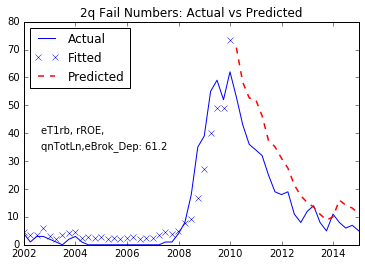

In [106]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.show()

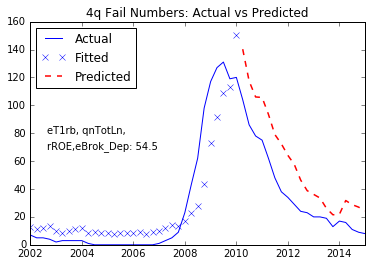

In [107]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')
plt.show()

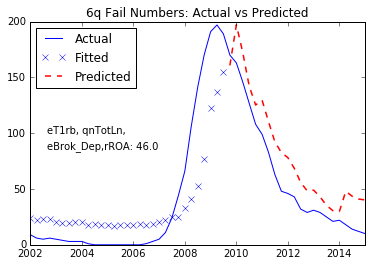

In [108]:
fx = list(fnbr.index)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=10) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')
plt.show()

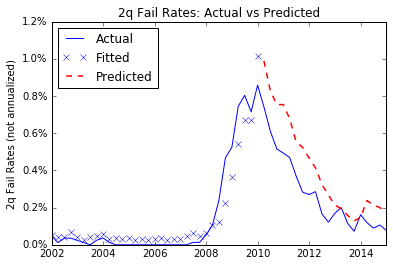

In [109]:
fx = list(fnbr.index)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')
plt.show()

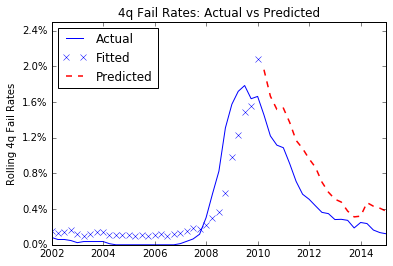

In [110]:
fx = list(fnbr.index)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')
plt.show()

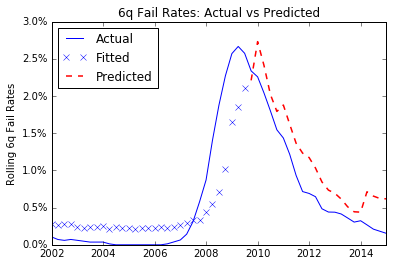

In [111]:
fx = list(fnbr.index)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')
plt.show()

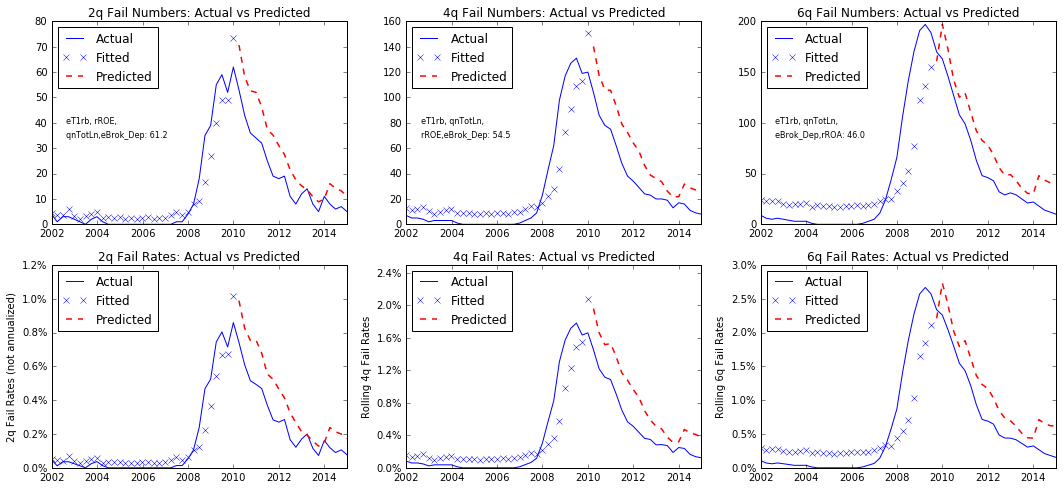

In [112]:
fx = list(fnbr.index)
params = plt.gcf()
plSize = params.get_size_inches()
params.set_size_inches( (plSize[0]*3, plSize[1]*2) )  ## double width, single height

plt.subplot(2, 3, 1)
plt.plot(fx, fnbr['f2'],'b', label='Actual')
plt.plot(fx, fnbr['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f2_0p'],'r--',lw=1.5, label='Predicted')
plt.legend(loc=2)
plt.title('2q Fail Numbers: Actual vs Predicted')
plt.annotate(dv4r[dv4r['idx']==0]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==0]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation

plt.subplot(2, 3, 2)
plt.plot(fx, fnbr['f4'],'b', label='Actual')
plt.plot(fx, fnbr['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f4_2p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==2]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==2]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('4q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 3)
plt.plot(fx, fnbr['f6'],'b', label='Actual')
plt.plot(fx, fnbr['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, fnbr['f6_4p'],'r--',lw=1.5, label='Predicted')
plt.annotate(dv4r[dv4r['idx']==4]['Annot1'].values[0], xy=(0.05, 0.5),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.annotate(dv4r[dv4r['idx']==4]['Annot2'].values[0], xy=(0.05, 0.43),\
             xycoords='axes fraction', fontsize=8) # var listing annotation
plt.legend(loc=2)
plt.title('6q Fail Numbers: Actual vs Predicted')

plt.subplot(2, 3, 4)
plt.plot(fx, favg['f2'],'b', label='Actual')
plt.plot(fx, favg['f2_0f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f2_0p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0121,.002)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('2q Fail Rates (not annualized)')
plt.legend(loc=2)
plt.title('2q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 5)
plt.plot(fx, favg['f4'],'b', label='Actual')
plt.plot(fx, favg['f4_2f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f4_2p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0241,.004)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 4q Fail Rates')
plt.legend(loc=2)
plt.title('4q Fail Rates: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.plot(fx, favg['f6'],'b', label='Actual')
plt.plot(fx, favg['f6_4f'],'b',ls=' ',marker='x', label='Fitted')
plt.plot(fx, favg['f6_4p'],'r--',lw=1.5, label='Predicted')
# convert decimals to percentages with % symbols:
ytix = np.arange(0,.0301,.005)  # list of ticks on y-axis
ylbl = ['{:3.1f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.ylabel('Rolling 6q Fail Rates')
plt.legend(loc=2)
plt.title('6q Fail Rates: Actual vs Predicted')

plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_nbrvsrate_allmods'+'.png', dpi=400, bbox_inches='tight')

plt.show()

In [113]:
fcol[-6:]

['f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

In [114]:
len(dff)

395257

In [115]:
ffb = dff[dff['FailDate']>'1999'][['IDRSSD','AsOf','Name','FailDate','eTotAst']+fcol[-6:]].groupby(['IDRSSD']).max()

In [116]:
ffb.sort_index(by='eTotAst',ascending=False,inplace=True)
ffb.reset_index(drop=False,inplace=True)

In [117]:
dff.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8', 'Intercept', 'f2_0', 'f2_1',
       'f4_2', 'f4_3', 'f6_4', 'f6_5'],
      dtype='object')

In [118]:
ffb.tail()

IDRSSD       AsOf                     Name   FailDate  eTotAst      f2_0  \
468  371915 2003-12-31            RELIANCE BANK 2004-03-19  31375.0  0.755086   
469  740258 2009-03-31           BANK OF LEETON 2010-01-22  26441.0  0.448043   
470  187358 2014-03-31  FREEDOM STATE BANK, THE 2014-06-27  23218.0  0.000227   
471  901956 2007-12-31                HUME BANK 2008-03-07  19681.0  0.000648   
472  475934 2001-12-31     STATE BANK OF LATHAM 2014-06-20   6470.0  0.000030   

         f2_1      f4_2      f4_3      f6_4      f6_5  
468  0.750560  0.955656  0.871350  0.917425  0.961953  
469  0.421924  0.783641  0.691208  0.705402  0.810606  
470  0.000144  0.001010  0.000842  0.002414  0.002639  
471  0.000391  0.002492  0.003066  0.006437  0.005208  
472  0.000013  0.000143  0.000075  0.000273  0.000417

In [119]:
ffb['Rank'] = ffb['eTotAst'].rank(ascending=False)
ffb.head()

IDRSSD       AsOf                         Name   FailDate       eTotAst  \
0   480228 2014-12-31          BANK OF AMERICA, NA 2009-01-16  1.574093e+09   
1   476810 2014-12-31               CITIBANK, N.A. 2008-11-23  1.377279e+09   
2  1830035 2014-09-30        MBNA AMERICA BANK, NA 2009-01-16  1.967486e+08   
3   486752 2011-03-31  CITIBANK (SOUTH DAKOTA), NA 2008-11-23  1.579352e+08   
4  1225800 2009-06-30       MERRILL LYNCH BANK USA 2009-01-16  7.813389e+07   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  Rank  
0  0.001324  0.022334  0.004427  0.005700  0.010916  0.009172   1.0  
1  0.001438  0.022605  0.005154  0.006556  0.012377  0.010334   2.0  
2  0.000745  0.005060  0.005393  0.063148  0.150706  0.012319   3.0  
3  0.025529  0.007399  0.133337  0.125318  0.252417  0.259579   4.0  
4  0.011493  0.065318  0.072194  0.057454  0.154416  0.157718   5.0

In [120]:
dff[dff['mtf']>0][['IDRSSD','mtf']].head(6)

IDRSSD         mtf
928    2451  102.704368
929    2451   99.747428
930    2451   96.757634
931    2451   93.734984
932    2451   90.712335
933    2451   87.755395

In [121]:
############### CAUTION  CAUTION #########################################
## DO NOT RUN UNLESS.....
## short-cut to skip all earlier processing!!!!!!!!!!!!!!!!!
############### CAUTION  CAUTION #########################################

#dff = pd.read_csv('allbanks_f2468_roe0mm2_20091231.csv', index_col=0)
#dff['AsOf'] = pd.to_datetime(dff['AsOf'])
#dff['FailDate'] = pd.to_datetime(dff['FailDate'])
############### CAUTION  CAUTION #########################################

fcol = [x for x in list(dff.columns) if x[0:1]=='f']
xcol=['rcTotLn','qnTotLn','rNIM','rPPNR','rROA','rROE','rEff','eLn_Dep','aFF_TA','eBrok_Dep','eT1rb','eTotrb','eALLL_Ln','lnTotAst']
dmtf=dff[dff['mtf2']>0][['mtf2']+xcol+fcol].groupby('mtf2').mean()
targ = pd.to_datetime('2009-12-31')
thresh = 0
alt = 'roe' ## or alt = ''  # add rROE >=-200 screening test

dff.head(2)

IDRSSD       AsOf                    Name State  eTotAst   rcTotLn  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY    GA  66624.0  0.320412   
1      37 2002-03-31  BANK OF HANCOCK COUNTY    GA  68766.0  0.261846   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  0.202341  4.771308  2.035791  1.366385    ...      0   0   0        1.0   
1  0.199812  4.673793  1.952308  1.314604    ...      0   0   0        1.0   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 33 columns]

In [122]:
dmtf.head()

rcTotLn    qnTotLn      rNIM     rPPNR      rROA        rROE  \
mtf2                                                                  
1.0   4.062733  14.341177  2.733547 -0.973354 -4.477772 -116.886291   
2.0   4.060887  13.592382  3.020471 -0.955685 -4.647219 -108.496117   
3.0   4.382689  14.408252  2.611824 -1.139766 -4.862807 -110.468070   
4.0   4.148183  13.998089  2.727931 -0.823067 -4.790189 -102.202372   
5.0   3.824606  12.884055  3.103476 -0.656428 -4.382754  -85.338416   

              rEff    eLn_Dep    aFF_TA  eBrok_Dep    ...      f2   f4   f6  \
mtf2                                                  ...                     
1.0    6870.775934  78.193744  8.967208  13.095352    ...     1.0  1.0  1.0   
2.0   15206.902663  78.597392  8.739900  10.594678    ...     1.0  1.0  1.0   
3.0    3049.254190  77.691097  7.586644  11.176513    ...     1.0  1.0  1.0   
4.0    8989.544164  84.572515  7.859185  13.852697    ...     1.0  1.0  1.0   
5.0   12224.413644  80.036189  7.650596  10.950816    ...     1.0  1.0  1.0   

       f8      f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
mtf2                                                                   
1.0   1.0  0.591574  0.608681  0.752613  0.667186  0.698317  0.785271  
2.0   1.0  0.542443  0.564438  0.723135  0.643125  0.678260  0.759289  
3.0   1.0  0.524810  0.542716  0.721478  0.646592  0.690188  0.766326  
4.0   1.0  0.477165  0.488423  0.687968  0.619721  0.667369  0.737828  
5.0   1.0  0.344718  0.366186  0.570767  0.520185  0.580037  0.634829  

[5 rows x 24 columns]

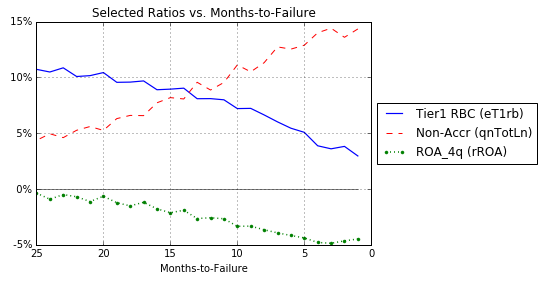

In [123]:
xm = list(dmtf.index)[0:25]
#dmtf.ix[0:25][['rcTotLn','qnTotLn','rROA','eT1rb']].plot()
plt.plot(xm,dmtf.ix[0:25]['eT1rb'],c='b',ls='-',lw=1.2,label='Tier1 RBC (eT1rb)')
plt.plot(xm,dmtf.ix[0:25]['qnTotLn'],c='r',ls='--',label='Non-Accr (qnTotLn)')
#plt.plot(xm,dmtf.ix[0:25]['rcTotLn'],c='b',label='NCO TotLn (r4q)')
plt.plot(xm,dmtf.ix[0:25]['rROA'],c='g',ls=':',lw=1.5,marker='.',label='ROA_4q (rROA)')
#plt.plot(xm,dmtf.ix[0:25]['eBrok_Dep'],c='g',ls='-.',lw=1.5,marker='x',label='Brok%Dep')
plt.plot(xm,[0]*25,'k',lw=.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ytix = np.arange(-5,15.1,5)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.grid()
plt.title("Selected Ratios vs. Months-to-Failure")
plt.gca().invert_xaxis()  ## inverts x-axis!!
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_ratiosvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [124]:
xm

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0]

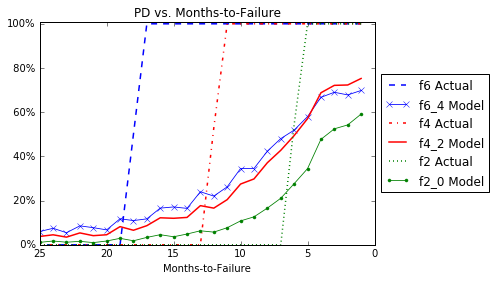

In [125]:
falt = ['f2_0','f4_2','f6_4']
#dmtf.ix[0:25][falt].plot()
plt.plot(xm,dmtf.ix[0:25]['f6'],c='b',ls='--',lw=1.5,label='f6 Actual')
plt.plot(xm,dmtf.ix[0:25]['f6_4'],c='b',ls='-',lw=.8,marker='x',label='f6_4 Model')
plt.plot(xm,dmtf.ix[0:25]['f4'],c='r',ls='-.',lw=1.5,label='f4 Actual')
plt.plot(xm,dmtf.ix[0:25]['f4_2'],c='r',lw=1.5,label='f4_2 Model')
plt.plot(xm,dmtf.ix[0:25]['f2'],c='g',ls=':',lw=1.5,label='f2 Actual')
plt.plot(xm,dmtf.ix[0:25]['f2_0'],c='g',ls='-',lw=.8,marker='.',label='f2_0 Model')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("PD vs. Months-to-Failure")
plt.ylim([0,1.01])
ytix = np.arange(0,1.1,.2)  # list of ticks on y-axis
ylbl = ['{:3.0f}%'.format(x*100) for x in ytix] # mult by 100 and add % symbol
plt.yticks(ytix, ylbl)
plt.xlabel('Months-to-Failure')
plt.gca().invert_xaxis()
plt.savefig('LR_'+alt+str(thresh)+'mm2_2009_pdsvsmtf'+'.png', dpi=300, bbox_inches='tight')
plt.show()

In [126]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [127]:
df11=dff[(dff['AsOf']=='2010-12-31')&(dff['FailDate']>'2011-01-01')&(dff['FailDate']<'2012-01-01')]
df11.sort_index(by='FailDate',inplace=True)
len(df11)

75

In [128]:
df11[['FailDate','Name','State','f2_0','f4_2','f6_4']][0:15]

FailDate                            Name State      f2_0      f4_2  \
385771 2011-01-07                     LEGACY BANK    AZ  0.369447  0.662182   
148806 2011-01-21      ENTERPRISE BANKING COMPANY    GA  0.904162  0.985704   
16811  2011-01-28           FIRST STATE BANK, THE    OK  0.000579  0.001730   
379754 2011-01-28                   FIRSTIER BANK    CO  0.979686  0.996981   
71139  2011-01-28            FIRST COMMUNITY BANK    NM  0.863226  0.973359   
388113 2011-02-04  COMMUNITY FIRST BANK - CHICAGO    IL  0.202498  0.474166   
363380 2011-02-04              NORTH GEORGIA BANK    GA  0.969234  0.995705   
378669 2011-02-04             AMERICAN TRUST BANK    GA  0.922173  0.985856   
227980 2011-02-11              PEOPLES STATE BANK    MI  0.942476  0.988253   
346837 2011-02-11            CANYON NATIONAL BANK    CA  0.701714  0.917501   
65300  2011-02-11               BADGER STATE BANK    WI  0.167351  0.420509   
365834 2011-02-11   SUNSHINE STATE COMMUNITY BANK    FL  0.883075  0.979421   
342273 2011-02-18      CITIZENS BANK OF EFFINGHAM    GA  0.874834  0.973369   
81522  2011-02-18                  HABERSHAM BANK    GA  0.851968  0.970404   
348359 2011-03-11                     LEGACY BANK    WI  0.974206  0.996698   

            f6_4  
385771  0.331050  
148806  0.977683  
16811   0.004410  
379754  0.967104  
71139   0.858734  
388113  0.337694  
363380  0.973021  
378669  0.905784  
227980  0.904814  
346837  0.744690  
65300   0.330722  
365834  0.877545  
342273  0.863428  
81522   0.899876  
348359  0.991465

In [129]:
df11[fcol].mean()

f2      0.453333
f4      1.000000
f6      1.000000
f8      1.000000
f2_0    0.426198
f2_1    0.457138
f4_2    0.652771
f4_3    0.581258
f6_4    0.636649
f6_5    0.715429
dtype: float64

In [130]:
df11.to_csv("2011failedbks_pds_20091231_"+alt+str(thresh)+"mm2.csv")

In [131]:
db11=dff[(dff['AsOf']=='2010-12-31')]
db11.sort_index(by='eTotAst',ascending=False,inplace=True)
db11[['Name']+fcol].head(10)

Name  f2  f4  f6  f8      f2_0      f2_1  \
259880       JPMORGAN CHASE BANK, NA   0   0   0   0  0.000795  0.014612   
146614           BANK OF AMERICA, NA   0   0   0   0  0.000511  0.008460   
145050                CITIBANK, N.A.   0   0   0   0  0.000057  0.001040   
137000          WELLS FARGO BANK, NA   0   0   0   0  0.000569  0.009063   
154279                  U.S. BANK NA   0   0   0   0  0.000823  0.008681   
249069                  PNC BANK, NA   0   0   0   0  0.000265  0.002779   
323252         FIA CARD SERVICES, NA   0   0   0   0  0.000068  0.000392   
164886  BANK OF NEW YORK MELLON, THE   0   0   0   0  0.000236  0.002334   
125815             HSBC BANK USA, NA   0   0   0   0  0.000209  0.001728   
151774                 TD BANK, N.A.   0   0   0   0  0.000247  0.000947   

            f4_2      f4_3      f6_4      f6_5  
259880  0.002995  0.003528  0.007858  0.006913  
146614  0.002138  0.001997  0.005041  0.005208  
145050  0.000310  0.000174  0.000691  0.000974  
137000  0.002168  0.002135  0.004909  0.004990  
154279  0.002789  0.003228  0.006397  0.005865  
249069  0.001146  0.000896  0.002477  0.002917  
323252  0.000381  0.000183  0.000712  0.001140  
164886  0.000925  0.000835  0.002103  0.002212  
125815  0.000951  0.000742  0.002194  0.002526  
151774  0.001464  0.000849  0.003102  0.004301

In [132]:
db11.to_csv("2011allbks_pds_20101231_"+alt+str(thresh)+"mm2.csv")

In [133]:
len(dff)

395257

In [134]:
varlst = ['qnTotLn', 'rROA', 'rROE','eBrok_Dep', 'eT1rb','lnTotAst']
varlst

['qnTotLn', 'rROA', 'rROE', 'eBrok_Dep', 'eT1rb', 'lnTotAst']

In [135]:
dff.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [136]:
"allbanks_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'allbanks_f2468_roe0mm2_20091231.csv'

In [137]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [138]:
len(dfr), len(dff)

(405040, 395257)

In [139]:
len(dfh)

259210

In [140]:
dfh.to_csv("modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv")

In [141]:
"modeldata_f2468_"+alt+str(thresh)+"mm2_"+str(targ.year)+str(targ.month)+str(targ.day)+".csv"

'modeldata_f2468_roe0mm2_20091231.csv'

In [142]:
dfh.head(2)

IDRSSD       AsOf                    Name FailDate  f2  f4  f6  f8  \
0      37 2001-12-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   
1      37 2002-03-31  BANK OF HANCOCK COUNTY      NaT   0   0   0   0   

    rcTotLn   qnTotLn    ...         eT1rb     eTotrb  eALLL_Ln   lnTotAst  \
0  0.320412  0.202341    ...     31.394061  32.659950  2.377511  11.106820   
1  0.261846  0.199812    ...     31.128485  32.396358  2.522930  11.138465   

           f2_0          f2_1          f4_2          f4_3          f6_4  \
0  1.816980e-08  2.457995e-08  2.658786e-07  1.808432e-08  3.640110e-07   
1  2.074132e-08  2.819496e-08  2.984160e-07  2.111511e-08  4.128278e-07   

       f6_5  
0  0.000002  
1  0.000002  

[2 rows x 28 columns]

In [143]:
dv4b

idx  fx     v1        r1       v2        r2         v3        r3  \
0  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
1  0.0  f2  eT1rb  0.522181     rROE  0.572503    qnTotLn  0.595651   
2  3.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROE  0.517804   
3  2.0  f4  eT1rb  0.399541  qnTotLn  0.485642       rROA  0.520306   
4  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   
5  4.0  f6  eT1rb  0.292186  qnTotLn  0.398684  eBrok_Dep  0.432376   

          v4        r4       Int        c1        c2        c3        c4  
0  eBrok_Dep  0.611862 -2.799821 -0.473018 -0.024956  0.084633  0.034710  
1   lnTotAst  0.605721 -6.621866 -0.450454 -0.028631  0.084570  0.310076  
2  eBrok_Dep  0.544661 -2.201785 -0.405928  0.112205 -0.028430  0.041345  
3  eBrok_Dep  0.543345 -0.967992 -0.524373  0.116511 -0.308563  0.038837  
4       rROA  0.460139 -1.308207 -0.418959  0.145417  0.042005 -0.288694  
5       rROE  0.458442 -2.075903 -0.346558  0.140125  0.043327 -0.025636

In [144]:
fcol

['f2', 'f4', 'f6', 'f8', 'f2_0', 'f2_1', 'f4_2', 'f4_3', 'f6_4', 'f6_5']

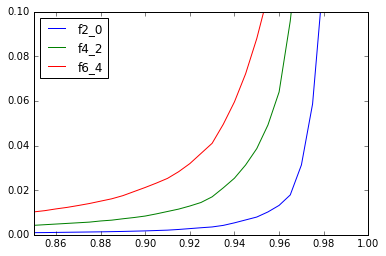

In [145]:
dpc0912 = dff[dff['AsOf']=='2009-12-31'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0912[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.85,1])
plt.legend(loc=2)

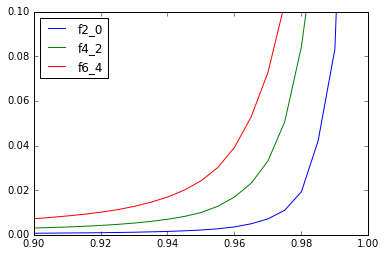

In [146]:
dpc0914 = dff[dff['AsOf']>'2009-01-01'][fcol[-6:]].quantile(np.arange(.01,1,.005))
dpc0914[['f2_0','f4_2','f6_4']].plot()
plt.ylim([0,.1])
plt.xlim([.9,1])
plt.legend(loc=2)

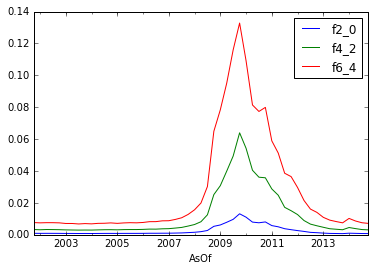

In [147]:
dpc96 = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile(.96)
dpc96[['f2_0','f4_2','f6_4']].plot()

In [148]:
dpc90p = dff[['AsOf']+fcol[-6:]].groupby('AsOf').quantile([.9,.92,.94,.96,.98])
dpc90p = dpc90p.unstack(1)
#dpc90p=dpc90p.swaplevel(0,1,axis=1)
dpc90p.sort_index(axis=1,inplace=True)
dpc90p.head(2)

f2_0                                              f2_1  \
                0.90      0.92      0.94      0.96      0.98      0.90   
AsOf                                                                     
2001-12-31  0.000591  0.000653  0.000755  0.000930  0.001373  0.000655   
2002-03-31  0.000571  0.000647  0.000739  0.000899  0.001346  0.000632   

                                                      ...         f6_4  \
                0.92      0.94      0.96      0.98    ...         0.90   
AsOf                                                  ...                
2001-12-31  0.000738  0.000856  0.001086  0.001629    ...     0.004779   
2002-03-31  0.000710  0.000823  0.001034  0.001545    ...     0.004692   

                                                        f6_5            \
                0.92      0.94      0.96      0.98      0.90      0.92   
AsOf                                                                     
2001-12-31  0.005318  0.006084  0.007674  0.011588  0.004325  0.004778   
2002-03-31  0.005309  0.006108  0.007496  0.011538  0.004282  0.004799   

                                          
                0.94      0.96      0.98  
AsOf                                      
2001-12-31  0.005454  0.006748  0.010242  
2002-03-31  0.005508  0.006723  0.010497  

[2 rows x 30 columns]

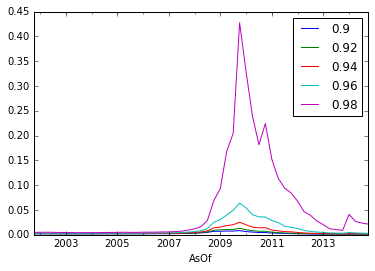

In [149]:
dpc90p['f4_2'].plot()

In [150]:
dfr0914 = dfr[dfr['AsOf']>'2009-01-01']
len(dfr0914)

169362

In [151]:
dfr.columns

Index(['IDRSSD', 'AsOf', 'Name', 'State', 'eTotAst', 'rcTotLn', 'qnTotLn',
       'rNIM', 'rPPNR', 'rROA', 'rROE', 'rEff', 'eLn_Dep', 'aFF_TA',
       'eBrok_Dep', 'eT1rb', 'eTotrb', 'eALLL_Ln', 'lnTotAst', 'FailDate',
       'mtf', 'mtf2', 'f2', 'f4', 'f6', 'f8'],
      dtype='object')

In [152]:
dfr0914.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dfr0914.reset_index(drop=True,inplace=True)
dfr0914.head(2)

IDRSSD       AsOf                     Name State       eTotAst   rcTotLn  \
0  852218 2009-03-31  JPMORGAN CHASE BANK, NA    OH  1.688164e+09  1.373904   
1  480228 2009-03-31      BANK OF AMERICA, NA    NC  1.432862e+09  1.475853   

    qnTotLn      rNIM     rPPNR      rROA ...     eTotrb  eALLL_Ln   lnTotAst  \
0  2.496176  2.523947  1.918733  0.699537 ...  12.679225  3.230925  21.246907   
1  3.152932  2.483742  1.831558  0.455510 ...  11.988809  2.002301  21.082940   

    FailDate       mtf  mtf2  f2  f4  f6 f8  
0        NaT       NaN   NaN   0   0   0  0  
1 2009-01-16 -2.431261  -2.0   0   0   0  0  

[2 rows x 26 columns]

In [153]:
dfr0914.to_csv("allbanks_f2468r_"+alt+str(thresh)+"mm2_2009_2014"+".csv")

In [154]:
dff0914 = dff[dff['AsOf']>'2009-01-01']
len(dff0914)

165272

In [155]:
dff0914.sort_index(by=['AsOf','eTotAst'],ascending=[True,False],inplace=True)
dff0914.reset_index(drop=True,inplace=True)
dff0914.head(2)

IDRSSD       AsOf                     Name State       eTotAst   rcTotLn  \
0  852218 2009-03-31  JPMORGAN CHASE BANK, NA    OH  1.688164e+09  1.373904   
1  480228 2009-03-31      BANK OF AMERICA, NA    NC  1.432862e+09  1.475853   

    qnTotLn      rNIM     rPPNR      rROA    ...     f4  f6  f8  Intercept  \
0  2.496176  2.523947  1.918733  0.699537    ...      0   0   0        1.0   
1  3.152932  2.483742  1.831558  0.455510    ...      0   0   0        1.0   

       f2_0      f2_1      f4_2      f4_3      f6_4      f6_5  
0  0.000926  0.016576  0.003195  0.003976  0.007878  0.006744  
1  0.001287  0.022138  0.004427  0.005700  0.010916  0.009172  

[2 rows x 33 columns]

In [156]:
dff0914.to_csv("allbanks_f2468_"+alt+str(thresh)+"mm2_2009_2014"+".csv")